Kiểm tra tương quan giữa nồng độ chất khử mùi và nồng độ mùi thực tế

Checking file existence...
File found: E:\Khóa luận\Data\Phase 1\0500.csv
File found: E:\Khóa luận\Data\Phase 2\250500.csv
File found: E:\Khóa luận\Data\Phase 2\500500.csv
File found: E:\Khóa luận\Data\Phase 2\750500.csv

Processing file: E:\Khóa luận\Data\Phase 1\0500.csv
  Success reading E:\Khóa luận\Data\Phase 1\0500.csv. Columns: ['Timestamp', 'Date time', 'ccseCO2', 'ccsTVOC', 'scdCO2', 'scdTEMP', 'scdHUMID', 'H2S_concentration', 'H2S_boardtemp', 'NH3_concentration', 'NH3_boardtemp', 'CH4ppm', 'CH4RAWppm', 'HCHOmg/m3', 'TVOCppm']
  DataFrame shape: (39292, 15)
    NH3_concentration: dtype=float64, mean=0.8923422016488597, NaNs=0, unique=35
    H2S_concentration: dtype=int64, mean=0.0, NaNs=0, unique=1
    TVOCppm: dtype=float64, mean=nan, NaNs=39292, unique=0
    CH4RAWppm: dtype=float64, mean=20.620768734672556, NaNs=0, unique=11962

Processing file: E:\Khóa luận\Data\Phase 2\250500.csv
  Success reading E:\Khóa luận\Data\Phase 2\250500.csv. Columns: ['Timestamp', 'Date time', '

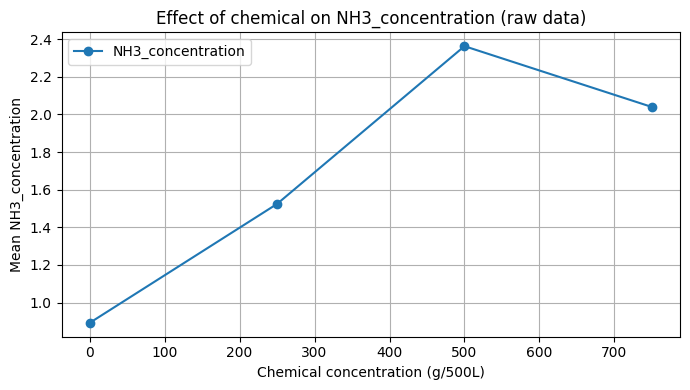

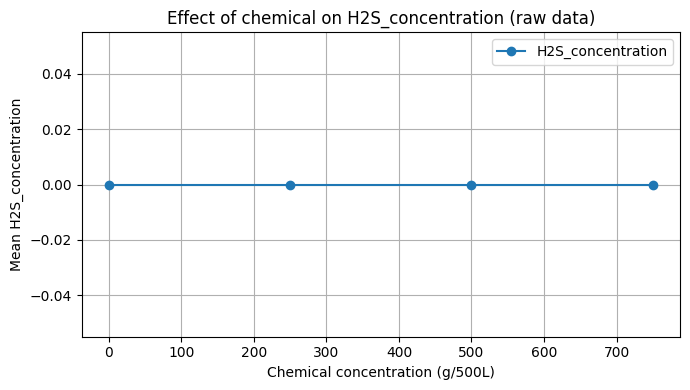

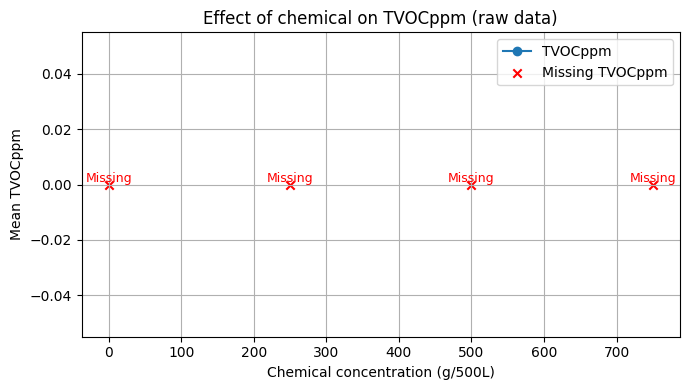

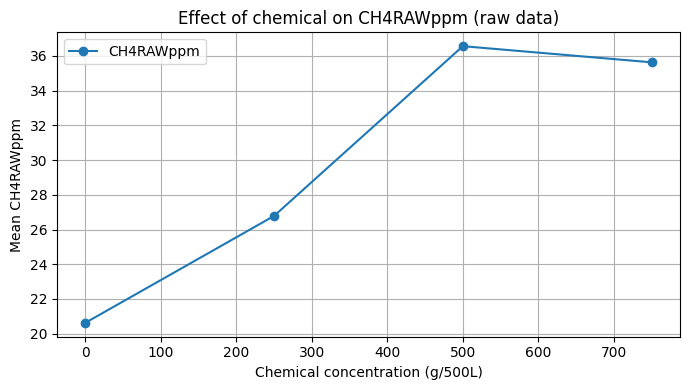

Correlation between chemical level and NH3_concentration (raw data): 0.860 (based on 4 levels)
Correlation between chemical level and H2S_concentration (raw data): nan (based on 4 levels)
Not enough data to compute correlation for TVOCppm
Correlation between chemical level and CH4RAWppm (raw data): 0.932 (based on 4 levels)


c:\Users\d5a2m\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\d5a2m\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_dir_phase2 = r'E:\Khóa luận\Data\Phase 2'
base_dir_phase1 = r'E:\Khóa luận\Data\Phase 1'

raw_files = {
    0: os.path.join(base_dir_phase1, '0500.csv'),
    250: os.path.join(base_dir_phase2, '250500.csv'),
    500: os.path.join(base_dir_phase2, '500500.csv'),
    750: os.path.join(base_dir_phase2, '750500.csv')
}

odor_cols = ['NH3_concentration', 'H2S_concentration', 'TVOCppm', 'CH4RAWppm']

# Check if files exist before processing
print("Checking file existence...")
for fp in raw_files.values():
    if not os.path.exists(fp):
        print(f"File does not exist: {fp}")
    else:
        print(f"File found: {fp}")

odor_means = {col: [] for col in odor_cols}
odor_missing = {col: [] for col in odor_cols}
concentration_levels = []

for level, file_path in raw_files.items():
    print(f"\nProcessing file: {file_path}")
    # Always use sep=';' for these files
    sep = ';'
    try:
        df = pd.read_csv(file_path, encoding="utf-8", sep=sep)
        print(f"  Success reading {file_path}. Columns: {df.columns.tolist()}")
    except Exception as e:
        print(f"  Error reading {file_path}: {e}")
        continue

    if df.empty:
        print(f"  WARNING: DataFrame for {file_path} is empty!")
    else:
        print(f"  DataFrame shape: {df.shape}")

    df.columns = [col.strip() for col in df.columns]
    concentration_levels.append(level)
    for col in odor_cols:
        if col in df.columns:
            # Force numeric conversion
            df[col] = pd.to_numeric(df[col], errors='coerce')
            mean_val = df[col].mean()
            print(f"    {col}: dtype={df[col].dtype}, mean={mean_val}, NaNs={df[col].isna().sum()}, unique={df[col].nunique()}")
            if np.isnan(mean_val):
                odor_means[col].append(np.nan)
                odor_missing[col].append(True)
            else:
                odor_means[col].append(mean_val)
                odor_missing[col].append(False)
        else:
            print(f"    Column {col} NOT FOUND in {file_path}")
            odor_means[col].append(np.nan)
            odor_missing[col].append(True)

# Plotting
for col in odor_cols:
    values = odor_means[col]
    missing = odor_missing[col]
    plt.figure(figsize=(7,4))
    valid_levels = [lvl for lvl, miss in zip(concentration_levels, missing) if not miss]
    valid_values = [v for v, miss in zip(values, missing) if not miss]
    plt.plot(valid_levels, valid_values, marker='o', label=f'{col}')
    for lvl, miss in zip(concentration_levels, missing):
        if miss:
            plt.scatter(lvl, 0, marker='x', color='red', label=f"Missing {col}" if lvl == concentration_levels[0] else "")
            plt.text(lvl, 0, 'Missing', color='red', ha='center', va='bottom', fontsize=9)
    plt.xlabel('Chemical concentration (g/500L)')
    plt.ylabel(f'Mean {col}')
    plt.title(f'Effect of chemical on {col} (raw data)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Correlation coefficients
for col in odor_cols:
    vals = np.array([v for v, miss in zip(odor_means[col], odor_missing[col]) if not miss], dtype=np.float64)
    lvls = np.array([lvl for lvl, miss in zip(concentration_levels, odor_missing[col]) if not miss])
    if len(vals) > 1:
        corr = np.corrcoef(lvls, vals)[0,1]
        print(f'Correlation between chemical level and {col} (raw data): {corr:.3f} (based on {len(vals)} levels)')
    else:
        print(f'Not enough data to compute correlation for {col}')